In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import shap

In [2]:
# Read Bitcoin price data
btc_price_df = pd.read_csv("data/BTC-USD.csv")
btc_price_df["Date"] = pd.to_datetime(btc_price_df["Date"])
btc_price_df.set_index("Date", inplace=True)
btc_price_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


In [3]:
# Transform Bitcoin price data
btc_price_df["Yesterday Open Change"] = btc_price_df["Open"] - btc_price_df["Open"].shift(1)
btc_price_df["Yesterday High Change"] = btc_price_df["High"] - btc_price_df["High"].shift(1)
btc_price_df["Yesterday Low Change"] = btc_price_df["Low"] - btc_price_df["Low"].shift(1)
btc_price_df["Yesterday Close Change"] = btc_price_df["Close"] - btc_price_df["Close"].shift(1)
btc_price_df["Yesterday Adj Close Change"] = btc_price_df["Adj Close"] - btc_price_df["Adj Close"].shift(1)
btc_price_df["Yesterday Volume Change"] = btc_price_df["Volume"] - btc_price_df["Volume"].shift(1)
btc_price_df["Adj Close Change"] = btc_price_df["Adj Close"].shift(-1) - btc_price_df["Adj Close"]
btc_price_df.head()

,Open,High,Low,Close,Adj Close,Volume,Yesterday Open Change,Yesterday High Change,Yesterday Low Change,Yesterday Close Change,Yesterday Adj Close Change,Yesterday Volume Change,Adj Close Change
Date,,,,,,,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,NaN,NaN,NaN,NaN,NaN,NaN,2753.115234
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,382.445312,3554.490235,287.595703,2753.115234,2753.115234,2.713512e+10,654.755860
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,2752.953125,1453.441406,2961.134765,654.755860,654.755860,1.079981e+10,-810.109375
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,81163475344,681.541016,-1168.339844,-3329.560547,-810.109375,-810.109375,2.498240e+09,2020.515625
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,-833.908203,997.371094,1498.431641,2020.515625,2020.515625,-1.361615e+10,2831.933593


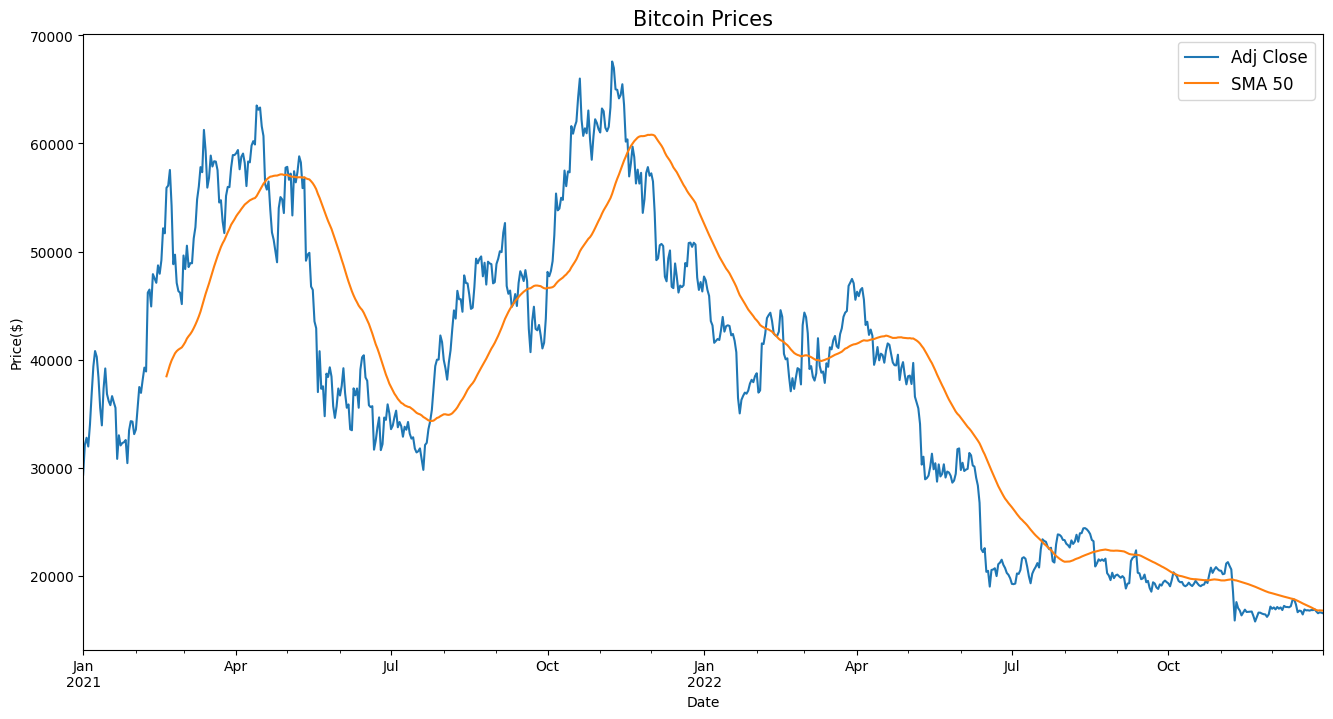

In [4]:
# Visualise Bitcoin prices
btc_price_df['Adj Close'].plot(figsize=(16,8))
btc_price_df['Adj Close'].rolling(50).mean().plot(label='SMA 50')
plt.title('Bitcoin Prices', fontsize=15)
plt.ylabel('Price($)')
plt.xlabel('Date')
plt.legend(fontsize=12)

In [5]:
# Read Coindesk news sentiment data on Bitcoin
news_sentiment_df = pd.read_csv("data/CoinDesk Sentiment.csv")
news_sentiment_df["Date"] = pd.to_datetime(news_sentiment_df["Date"])
news_sentiment_df.set_index("Date", inplace=True)
news_sentiment_df.head()

,Page,Pos title count,Neu title count,Neg title count,Pos content count,Neu content count,Neg content count,Title proportion pos,Title proportion neu,Title proportion neg,Content proportion pos,Content proportion neu,Content proportion neg
Date,,,,,,,,,,,,,
2021-01-02,13122,0,10,0,3,7,0,0.000000,1.000000,0.000000,0.300000,0.700000,0.000000
2021-01-03,25132,2,15,3,4,13,3,0.100000,0.750000,0.150000,0.200000,0.650000,0.150000
2021-01-04,22700,2,15,2,2,16,1,0.105263,0.789474,0.105263,0.105263,0.842105,0.052632
2021-01-05,3408,0,2,1,0,2,1,0.000000,0.666667,0.333333,0.000000,0.666667,0.333333
2021-01-06,5380,1,4,0,0,5,0,0.200000,0.800000,0.000000,0.000000,1.000000,0.000000


In [6]:
# Read Twitter sentiment data on Bitcoin
twitter_sentiment_df = pd.read_csv("data/Tweet Sentiments.csv")
twitter_sentiment_df["date"] = pd.to_datetime(twitter_sentiment_df["date"])
twitter_sentiment_df.set_index("date", inplace=True)
twitter_sentiment_df.head()

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.


,Tweet count,Retweet count,Like count,Avg VADER Neg,Avg VADER Neu,Avg VADER Pos,Avg VADER Comp,Avg VADER Score,FinBert Pos count,FinBert Neu count,FinBert Neg count,FinBert proportion Pos,FinBert proportion Neu,FinBert proportion Neg
date,,,,,,,,,,,,,,
2021-01-01,267,125,495,8.326,235.815,22.861,57.2243,2.079059e+05,16,243,8,0.059925,0.910112,0.029963
2021-02-01,501,715,5579,19.608,446.166,35.235,73.2517,9.492599e+05,30,461,10,0.059880,0.920160,0.019960
2021-03-01,486,281,1454,16.857,427.194,41.953,101.3046,7.431203e+04,38,442,6,0.078189,0.909465,0.012346
2021-04-01,365,154,1241,15.367,321.453,28.183,64.8278,3.826672e+05,23,326,16,0.063014,0.893151,0.043836
2021-05-01,347,1032,2375,11.616,304.041,31.355,87.4927,1.405275e+06,20,323,4,0.057637,0.930836,0.011527


In [7]:
# Combine Bitcoin price data, Coindesk news sentiment data and Twitter sentiment data
btc_df =  pd.concat([btc_price_df, news_sentiment_df, twitter_sentiment_df], axis=1)
btc_df.drop(["Page"], axis=1, inplace=True)
btc_df.fillna(0, inplace=True)
btc_df.head()

,Open,High,Low,Close,Adj Close,Volume,Yesterday Open Change,Yesterday High Change,Yesterday Low Change,Yesterday Close Change,...,Avg VADER Neu,Avg VADER Pos,Avg VADER Comp,Avg VADER Score,FinBert Pos count,FinBert Neu count,FinBert Neg count,FinBert proportion Pos,FinBert proportion Neu,FinBert proportion Neg
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,4.073030e+10,0.000000,0.000000,0.000000,0.000000,...,235.815,22.861,57.2243,2.079059e+05,16.0,243.0,8.0,0.059925,0.910112,0.029963
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,6.786542e+10,382.445312,3554.490235,287.595703,2753.115234,...,374.471,43.820,165.7896,7.279661e+05,11.0,412.0,5.0,0.025701,0.962617,0.011682
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,7.866524e+10,2752.953125,1453.441406,2961.134765,654.755860,...,368.055,35.863,77.9114,2.108665e+06,21.0,395.0,6.0,0.049763,0.936019,0.014218
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,8.116348e+10,681.541016,-1168.339844,-3329.560547,-810.109375,...,246.877,23.406,68.8920,3.343670e+06,15.0,258.0,5.0,0.053957,0.928058,0.017986
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,6.754732e+10,-833.908203,997.371094,1498.431641,2020.515625,...,340.592,52.014,146.7533,2.016835e+06,16.0,380.0,6.0,0.039801,0.945274,0.014925


In [8]:
# Observe features having correlation to 'Adj Close Change' column > 0.02
btc_df.corr()["Adj Close Change"][(btc_df.corr()["Adj Close Change"]>0.02) | (btc_df.corr()["Adj Close Change"]<-0.02)]

Open                         -0.033211
High                         -0.034634
Low                          -0.037710
Close                        -0.036132
Adj Close                    -0.036132
Yesterday High Change        -0.026078
Yesterday Low Change         -0.057106
Yesterday Close Change       -0.034118
Yesterday Adj Close Change   -0.034118
Yesterday Volume Change       0.033926
Adj Close Change              1.000000
Neu title count               0.030185
Neg title count               0.029468
Neu content count             0.031935
Neg content count             0.027673
Title proportion pos         -0.039230
Title proportion neu          0.023992
Title proportion neg          0.066692
Content proportion pos       -0.026572
Content proportion neg        0.069265
Tweet count                  -0.024061
Avg VADER Neu                -0.023190
Avg VADER Pos                -0.042790
Avg VADER Comp               -0.056223
FinBert Pos count            -0.040952
FinBert Neu count        

In [9]:
# Let explanatory variables for the model be those features having correlation to 'Adj Close Change' column > 0.02
cols = btc_df.corr()["Adj Close Change"][(btc_df.corr()["Adj Close Change"]>0.02) | (btc_df.corr()["Adj Close Change"]<-0.02)]
btc_df = btc_df[cols.index]
btc_df.drop('Adj Close Change', axis=1, inplace=True)
btc_df

,Open,High,Low,Close,Adj Close,Yesterday High Change,Yesterday Low Change,Yesterday Close Change,Yesterday Adj Close Change,Yesterday Volume Change,...,Content proportion pos,Content proportion neg,Tweet count,Avg VADER Neu,Avg VADER Pos,Avg VADER Comp,FinBert Pos count,FinBert Neu count,FinBert Neg count,FinBert proportion Neg
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,267.0,235.815,22.861,57.2243,16.0,243.0,8.0,0.029963
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,3554.490235,287.595703,2753.115234,2753.115234,2.713512e+10,...,0.300000,0.000000,428.0,374.471,43.820,165.7896,11.0,412.0,5.0,0.011682
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,1453.441406,2961.134765,654.755860,654.755860,1.079981e+10,...,0.200000,0.150000,422.0,368.055,35.863,77.9114,21.0,395.0,6.0,0.014218
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,-1168.339844,-3329.560547,-810.109375,-810.109375,2.498240e+09,...,0.105263,0.052632,278.0,246.877,23.406,68.8920,15.0,258.0,5.0,0.017986
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,997.371094,1498.431641,2020.515625,2020.515625,-1.361615e+10,...,0.000000,0.333333,402.0,340.592,52.014,146.7533,16.0,380.0,6.0,0.014925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.0,0.000,0.000,0.0000,0.0,0.0,0.0,0.000000
2023-10-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.0,0.000,0.000,0.0000,0.0,0.0,0.0,0.000000
2023-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.0,0.000,0.000,0.0000,0.0,0.0,0.0,0.000000
2023-11-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.0,0.000,0.000,0.0000,0.0,0.0,0.0,0.000000


In [10]:
# Create explanatory variables with 15 timesteps and target variable with 1 output
X=[]
y=[]

timestep = 2
for i in range(1,len(btc_price_df)-1-timestep):
    new_X = []
    for j in range(i, i+timestep):
        new_X.extend(btc_df.iloc[j,:])
    X.append(new_X) 
    y.append(btc_price_df.iloc[i,-1])
    
sc = MinMaxScaler()
X = sc.fit_transform(np.reshape(X, (len(X), len(btc_df.columns)*timestep))) 

In [11]:
# Split data into training, validation and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,shuffle=False) 

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
X_val, y_val = np.array(X_val), np.array(y_val)

In [12]:
# Create ANN model
ann = Sequential()
ann.add(Dense(units=40,activation="relu", input_dim=X_train.shape[1]))
ann.add(Dropout(0.3))
ann.add(Dense(units=30,activation="relu"))
ann.add(Dropout(0.3))
ann.add(Dense(units=10,activation="relu"))
ann.add(Dropout(0.2))
ann.add(Dense(units=1))
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                2200      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                1230      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

In [13]:
# Compile and run ANN model
ann.compile(optimizer="adam",loss="mean_squared_error",metrics=['mse'])
history = ann.fit(X_train,y_train,batch_size=32,epochs = 500, validation_data=(X_val, y_val))

Epoch 1/500
15/15 [==============================] - 1s 16ms/step - loss: 3266108.5000 - mse: 3266108.5000 - val_loss: 1135225.0000 - val_mse: 1135225.0000
Epoch 2/500
15/15 [==============================] - 0s 5ms/step - loss: 3265996.5000 - mse: 3265996.5000 - val_loss: 1135220.8750 - val_mse: 1135220.8750
Epoch 3/500
15/15 [==============================] - 0s 5ms/step - loss: 3265938.0000 - mse: 3265938.0000 - val_loss: 1135209.6250 - val_mse: 1135209.6250
Epoch 4/500
15/15 [==============================] - 0s 4ms/step - loss: 3265759.5000 - mse: 3265759.5000 - val_loss: 1135200.1250 - val_mse: 1135200.1250
Epoch 5/500
15/15 [==============================] - 0s 5ms/step - loss: 3265381.7500 - mse: 3265381.7500 - val_loss: 1135275.8750 - val_mse: 1135275.8750
Epoch 6/500
15/15 [==============================] - 0s 4ms/step - loss: 3265419.5000 - mse: 3265419.5000 - val_loss: 1135205.2500 - val_mse: 1135205.2500
Epoch 7/500
15/15 [==============================] - 0s 5ms/step - lo

Epoch 54/500
15/15 [==============================] - 0s 4ms/step - loss: 1447820.2500 - mse: 1447820.2500 - val_loss: 626433.8125 - val_mse: 626433.8125
Epoch 55/500
15/15 [==============================] - 0s 4ms/step - loss: 1294882.7500 - mse: 1294882.7500 - val_loss: 540565.5000 - val_mse: 540565.5000
Epoch 56/500
15/15 [==============================] - 0s 4ms/step - loss: 1254883.1250 - mse: 1254883.1250 - val_loss: 562362.9375 - val_mse: 562362.9375
Epoch 57/500
15/15 [==============================] - 0s 4ms/step - loss: 1284648.3750 - mse: 1284648.3750 - val_loss: 548790.1250 - val_mse: 548790.1250
Epoch 58/500
15/15 [==============================] - 0s 4ms/step - loss: 1173442.3750 - mse: 1173442.3750 - val_loss: 531396.1875 - val_mse: 531396.1875
Epoch 59/500
15/15 [==============================] - 0s 4ms/step - loss: 1207586.8750 - mse: 1207586.8750 - val_loss: 573019.3750 - val_mse: 573019.3750
Epoch 60/500
15/15 [==============================] - 0s 5ms/step - loss: 12

15/15 [==============================] - 0s 4ms/step - loss: 870860.8125 - mse: 870860.8125 - val_loss: 256573.8906 - val_mse: 256573.8906
Epoch 108/500
15/15 [==============================] - 0s 4ms/step - loss: 779192.4375 - mse: 779192.4375 - val_loss: 269430.4688 - val_mse: 269430.4688
Epoch 109/500
15/15 [==============================] - 0s 4ms/step - loss: 837540.4375 - mse: 837540.4375 - val_loss: 287826.2812 - val_mse: 287826.2812
Epoch 110/500
15/15 [==============================] - 0s 4ms/step - loss: 801588.4375 - mse: 801588.4375 - val_loss: 232906.9688 - val_mse: 232906.9688
Epoch 111/500
15/15 [==============================] - 0s 4ms/step - loss: 805124.4375 - mse: 805124.4375 - val_loss: 247621.5156 - val_mse: 247621.5156
Epoch 112/500
15/15 [==============================] - 0s 5ms/step - loss: 916498.7500 - mse: 916498.7500 - val_loss: 221941.4844 - val_mse: 221941.4844
Epoch 113/500
15/15 [==============================] - 0s 5ms/step - loss: 931981.8125 - mse: 93

15/15 [==============================] - 0s 4ms/step - loss: 737839.3125 - mse: 737839.3125 - val_loss: 191690.5000 - val_mse: 191690.5000
Epoch 161/500
15/15 [==============================] - 0s 4ms/step - loss: 587923.8750 - mse: 587923.8750 - val_loss: 154954.0312 - val_mse: 154954.0312
Epoch 162/500
15/15 [==============================] - 0s 4ms/step - loss: 560170.6250 - mse: 560170.6250 - val_loss: 158629.4688 - val_mse: 158629.4688
Epoch 163/500
15/15 [==============================] - 0s 4ms/step - loss: 601509.5625 - mse: 601509.5625 - val_loss: 160627.2969 - val_mse: 160627.2969
Epoch 164/500
15/15 [==============================] - 0s 4ms/step - loss: 668805.7500 - mse: 668805.7500 - val_loss: 146701.7812 - val_mse: 146701.7812
Epoch 165/500
15/15 [==============================] - 0s 4ms/step - loss: 528685.6250 - mse: 528685.6250 - val_loss: 165843.4531 - val_mse: 165843.4531
Epoch 166/500
15/15 [==============================] - 0s 4ms/step - loss: 606240.1250 - mse: 60

15/15 [==============================] - 0s 4ms/step - loss: 423073.5625 - mse: 423073.5625 - val_loss: 101902.3516 - val_mse: 101902.3516
Epoch 214/500
15/15 [==============================] - 0s 4ms/step - loss: 433313.0312 - mse: 433313.0312 - val_loss: 105870.6562 - val_mse: 105870.6562
Epoch 215/500
15/15 [==============================] - 0s 4ms/step - loss: 460649.0312 - mse: 460649.0312 - val_loss: 103679.3125 - val_mse: 103679.3125
Epoch 216/500
15/15 [==============================] - 0s 4ms/step - loss: 460282.8750 - mse: 460282.8750 - val_loss: 105268.8594 - val_mse: 105268.8594
Epoch 217/500
15/15 [==============================] - 0s 4ms/step - loss: 460134.5312 - mse: 460134.5312 - val_loss: 95829.6406 - val_mse: 95829.6406
Epoch 218/500
15/15 [==============================] - 0s 4ms/step - loss: 443721.0625 - mse: 443721.0625 - val_loss: 112363.0156 - val_mse: 112363.0156
Epoch 219/500
15/15 [==============================] - 0s 4ms/step - loss: 447317.2812 - mse: 4473

15/15 [==============================] - 0s 4ms/step - loss: 357154.3438 - mse: 357154.3438 - val_loss: 74098.2734 - val_mse: 74098.2734
Epoch 268/500
15/15 [==============================] - 0s 4ms/step - loss: 372290.4375 - mse: 372290.4375 - val_loss: 67866.0000 - val_mse: 67866.0000
Epoch 269/500
15/15 [==============================] - 0s 4ms/step - loss: 423241.3750 - mse: 423241.3750 - val_loss: 81008.8281 - val_mse: 81008.8281
Epoch 270/500
15/15 [==============================] - 0s 4ms/step - loss: 415691.5938 - mse: 415691.5938 - val_loss: 84174.3516 - val_mse: 84174.3516
Epoch 271/500
15/15 [==============================] - 0s 4ms/step - loss: 396482.2188 - mse: 396482.2188 - val_loss: 63440.9531 - val_mse: 63440.9531
Epoch 272/500
15/15 [==============================] - 0s 4ms/step - loss: 322589.7500 - mse: 322589.7500 - val_loss: 54507.8633 - val_mse: 54507.8633
Epoch 273/500
15/15 [==============================] - 0s 4ms/step - loss: 344631.7812 - mse: 344631.7812 - 

15/15 [==============================] - 0s 4ms/step - loss: 358964.9688 - mse: 358964.9688 - val_loss: 46714.6367 - val_mse: 46714.6367
Epoch 322/500
15/15 [==============================] - 0s 4ms/step - loss: 383518.2500 - mse: 383518.2500 - val_loss: 42474.6211 - val_mse: 42474.6211
Epoch 323/500
15/15 [==============================] - 0s 4ms/step - loss: 375994.2188 - mse: 375994.2188 - val_loss: 66370.0312 - val_mse: 66370.0312
Epoch 324/500
15/15 [==============================] - 0s 4ms/step - loss: 394366.3125 - mse: 394366.3125 - val_loss: 63547.3711 - val_mse: 63547.3711
Epoch 325/500
15/15 [==============================] - 0s 4ms/step - loss: 360974.2812 - mse: 360974.2812 - val_loss: 48407.0352 - val_mse: 48407.0352
Epoch 326/500
15/15 [==============================] - 0s 4ms/step - loss: 416856.0000 - mse: 416856.0000 - val_loss: 53426.7852 - val_mse: 53426.7852
Epoch 327/500
15/15 [==============================] - 0s 4ms/step - loss: 355430.9062 - mse: 355430.9062 - 

15/15 [==============================] - 0s 5ms/step - loss: 315743.9688 - mse: 315743.9688 - val_loss: 48663.9648 - val_mse: 48663.9648
Epoch 376/500
15/15 [==============================] - 0s 4ms/step - loss: 406926.2500 - mse: 406926.2500 - val_loss: 52385.9531 - val_mse: 52385.9531
Epoch 377/500
15/15 [==============================] - 0s 4ms/step - loss: 434312.4062 - mse: 434312.4062 - val_loss: 48784.3906 - val_mse: 48784.3906
Epoch 378/500
15/15 [==============================] - 0s 4ms/step - loss: 387181.2500 - mse: 387181.2500 - val_loss: 54299.3438 - val_mse: 54299.3438
Epoch 379/500
15/15 [==============================] - 0s 4ms/step - loss: 324879.6250 - mse: 324879.6250 - val_loss: 30454.3730 - val_mse: 30454.3730
Epoch 380/500
15/15 [==============================] - 0s 5ms/step - loss: 338180.4062 - mse: 338180.4062 - val_loss: 54943.1641 - val_mse: 54943.1641
Epoch 381/500
15/15 [==============================] - 0s 5ms/step - loss: 415639.2500 - mse: 415639.2500 - 

15/15 [==============================] - 0s 3ms/step - loss: 345396.8125 - mse: 345396.8125 - val_loss: 24434.2871 - val_mse: 24434.2871
Epoch 430/500
15/15 [==============================] - 0s 4ms/step - loss: 313635.3125 - mse: 313635.3125 - val_loss: 40088.7148 - val_mse: 40088.7148
Epoch 431/500
15/15 [==============================] - 0s 4ms/step - loss: 326957.3750 - mse: 326957.3750 - val_loss: 40328.9844 - val_mse: 40328.9844
Epoch 432/500
15/15 [==============================] - 0s 4ms/step - loss: 417651.2500 - mse: 417651.2500 - val_loss: 24964.5039 - val_mse: 24964.5039
Epoch 433/500
15/15 [==============================] - 0s 4ms/step - loss: 358129.2188 - mse: 358129.2188 - val_loss: 35707.1719 - val_mse: 35707.1719
Epoch 434/500
15/15 [==============================] - 0s 4ms/step - loss: 331457.5312 - mse: 331457.5312 - val_loss: 37388.8906 - val_mse: 37388.8906
Epoch 435/500
15/15 [==============================] - 0s 5ms/step - loss: 318605.2188 - mse: 318605.2188 - 

15/15 [==============================] - 0s 4ms/step - loss: 336322.5312 - mse: 336322.5312 - val_loss: 33905.8359 - val_mse: 33905.8359
Epoch 484/500
15/15 [==============================] - 0s 4ms/step - loss: 295713.2812 - mse: 295713.2812 - val_loss: 45096.7188 - val_mse: 45096.7188
Epoch 485/500
15/15 [==============================] - 0s 4ms/step - loss: 407416.6875 - mse: 407416.6875 - val_loss: 30345.4531 - val_mse: 30345.4531
Epoch 486/500
15/15 [==============================] - 0s 4ms/step - loss: 344304.0000 - mse: 344304.0000 - val_loss: 27866.6465 - val_mse: 27866.6465
Epoch 487/500
15/15 [==============================] - 0s 4ms/step - loss: 356972.6250 - mse: 356972.6250 - val_loss: 39672.9844 - val_mse: 39672.9844
Epoch 488/500
15/15 [==============================] - 0s 4ms/step - loss: 279736.7188 - mse: 279736.7188 - val_loss: 32861.6367 - val_mse: 32861.6367
Epoch 489/500
15/15 [==============================] - 0s 4ms/step - loss: 294709.8125 - mse: 294709.8125 - 

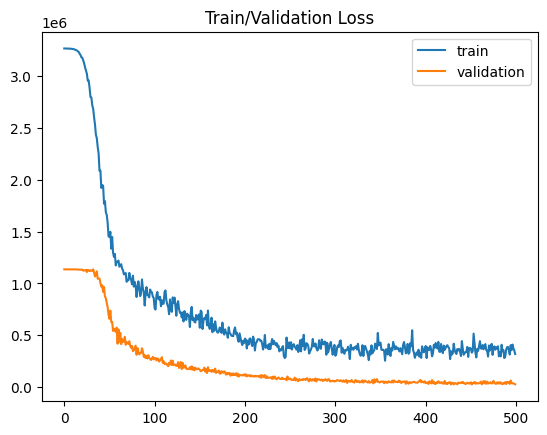

In [14]:
# Observe training loss and validation loss from the ANN model
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [15]:
# Calculate Bitcoin price prediction data
actual_price = np.array(btc_price_df[1+len(X_train)+len(X_val):len(btc_price_df)-timestep-1]["Adj Close"]) + y_test

predicted_price_diff = ann.predict(X_test)
predicted_price = np.array(btc_price_df[1+len(X_train)+len(X_val):len(btc_price_df)-timestep-1]["Adj Close"]) + np.reshape(predicted_price_diff, len(predicted_price_diff))

5/5 [==============================] - 0s 1ms/step


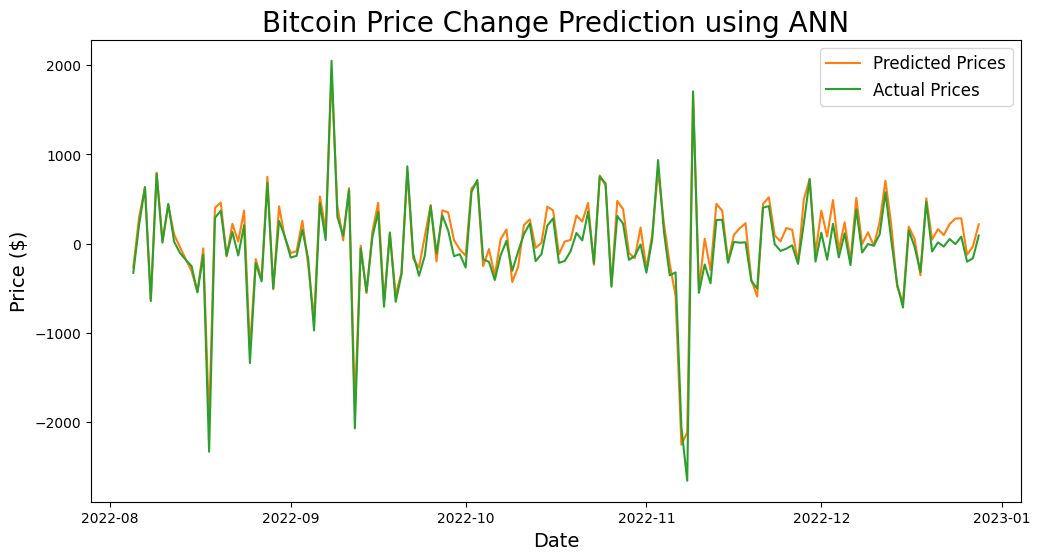

In [16]:
# Plot Bitcoin price change prediction data
plt.figure(figsize=(12, 6))

plt.plot(btc_price_df.iloc[1+len(X_train)+len(X_val):len(btc_price_df)-timestep-1].index, predicted_price_diff, label = 'Predicted Prices', color="tab:orange")
plt.plot(btc_price_df.iloc[1+len(X_train)+len(X_val):len(btc_price_df)-timestep-1].index, y_test, label = 'Actual Prices', color="tab:green")

plt.title('Bitcoin Price Change Prediction using ANN', size=20)
plt.xlabel('Date', size=14)
plt.ylabel('Price ($)', size=14)
plt.legend(fontsize=12)
plt.show()

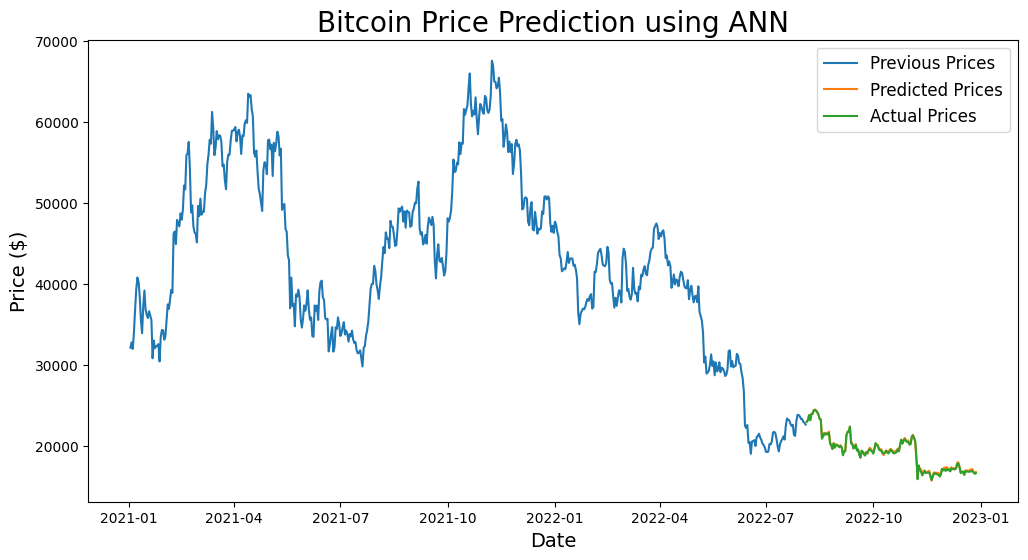

In [47]:
# Plot Bitcoin price prediction data (with historical prices)
plt.figure(figsize=(12, 6))

plt.plot(btc_price_df.iloc[1:1+len(X_train)+len(X_val)].index, btc_price_df.iloc[1:1+len(X_train)+len(X_val)]['Adj Close'], label='Previous Prices', color="tab:blue")
plt.plot(btc_price_df.iloc[1+len(X_train)+len(X_val):len(btc_price_df)-timestep-1].index, predicted_price, label = 'Predicted Prices', color="tab:orange")
plt.plot(btc_price_df.iloc[1+len(X_train)+len(X_val):len(btc_price_df)-timestep-1].index, actual_price, label = 'Actual Prices', color="tab:green")

plt.title('Bitcoin Price Prediction using ANN', size=20)
plt.xlabel('Date', size=14)
plt.ylabel('Price ($)', size=14)
plt.legend(fontsize=12)
plt.show()

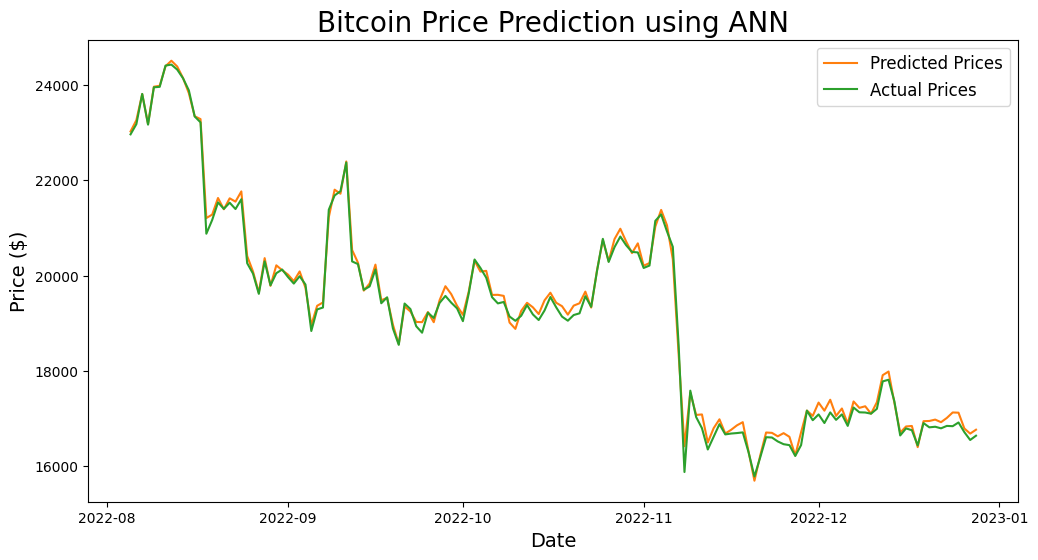

In [18]:
# Plot Bitcoin price prediction data
plt.figure(figsize=(12, 6))

plt.plot(btc_price_df.iloc[1+len(X_train)+len(X_val):len(btc_price_df)-timestep-1].index, predicted_price, label = 'Predicted Prices', color="tab:orange")
plt.plot(btc_price_df.iloc[1+len(X_train)+len(X_val):len(btc_price_df)-timestep-1].index, actual_price, label = 'Actual Prices', color="tab:green")

plt.title('Bitcoin Price Prediction using ANN', size=20)
plt.xlabel('Date', size=14)
plt.ylabel('Price ($)', size=14)
plt.legend(fontsize=12)
plt.show()

In [19]:
# Calculate ANN model performance
y_pred = np.reshape(predicted_price_diff, (1,len(predicted_price_diff)))[0]

ann_r2 = r2_score(y_test, y_pred)
ann_mse = mean_squared_error(y_test, y_pred)
ann_rmse = math.sqrt(ann_mse)

print("ANN Model Performance")
print(f"R2 Score: {round(ann_r2,3)}")
print(f"MSE Score: {round(ann_mse,3)}")
print(f"RMSE Score: {round(ann_rmse,3)}")

ANN Model Performance
R2 Score: 0.944
MSE Score: 17758.28
RMSE Score: 133.26


In [49]:
np.std(y_test)

562.6193027536332

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


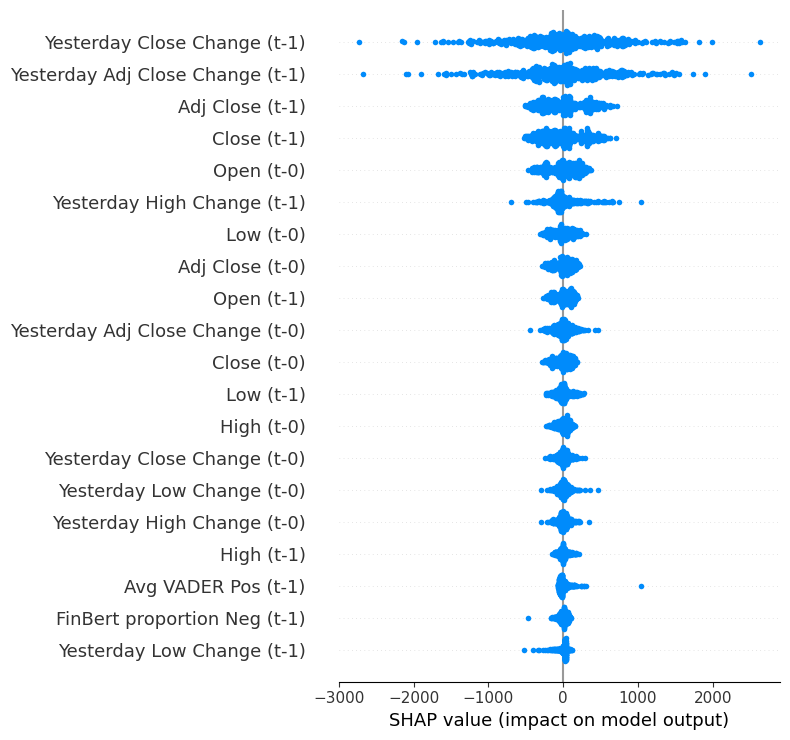

In [43]:
# Plot feature importance
feature_names = []
for i in range (timestep):
    feature_names.extend(btc_df.columns + " (t-" + str(i) + ")")
    
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
explainer = shap.DeepExplainer(ann, X_train)
shap_values = explainer.shap_values(X_train[:500])

shap.initjs()
shap.summary_plot(shap_values[0], feature_names=feature_names, plot_size=0.3)
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], X_train[0,:], feature_names=feature_names)

In [45]:
btc_df.mean()

Open                          3.501077e+04
High                          3.588973e+04
Low                           3.398761e+04
Close                         3.498943e+04
Adj Close                     3.498943e+04
Yesterday High Change        -1.644061e+01
Yesterday Low Change         -1.557169e+01
Yesterday Close Change       -1.625685e+01
Yesterday Adj Close Change   -1.625685e+01
Yesterday Volume Change      -3.737784e+07
Neu title count               7.097592e-02
Neg title count               7.604563e-03
Neu content count             6.717364e-02
Neg content count             7.604563e-03
Title proportion pos          1.464212e-03
Title proportion neu          9.196629e-03
Title proportion neg          7.460032e-04
Content proportion pos        1.400841e-03
Content proportion neg        1.101772e-03
Tweet count                   2.879975e+02
Avg VADER Neu                 2.545645e+02
Avg VADER Pos                 2.118458e+01
Avg VADER Comp                4.017859e+01
FinBert Pos